In [1]:
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# import mnist dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# Training parameters
num_steps = 10000
batch_size = 128
lr_generator = 2e-3
lr_discriminator = 2e-3

# network parameters
image_dim = 784 # mnist image 28*28*1
noise_dim = 100 # noise data points

In [4]:
# build networks
# network inputs
noise_input = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])

# a boolean to indicate batch normalization if it is training or inference time
is_training = tf.placeholder(tf.bool)

# LeakeyReLU
def leakeyrelu(x, alpha=0.2):
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)

# Genetator network
# Input: Noise, Output: Image
# Note that batch normalization has different behavior at training and inference time
# we then use placeholder to indicate the layer if we are training or not.
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        print("\nGenerator:")
        # tensorflow layer automatically create variables and 
        # calculate their shape, based on the input.
        x = tf.layers.dense(x, units=7*7*128)
        print("1st dense layer:", x)
        x = tf.layers.batch_normalization(x, training=is_training)
        print("1st BN layer:", x)
        x = tf.nn.relu(x)
        print("1st relu layer:", x)
        
        # reshape to a 4D array of images: [batch, height, width, channels]
        # new shape: (batch, 7, 7, 128)
        x = tf.reshape(x, shape=[-1, 7, 7, 128])
        print("reshape layer:", x)
        
        # deconvolution, image shape: (batch, 14, 14, 64)
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        print("2nd deconv layer:", x)
        x = tf.layers.batch_normalization(x, training=is_training)
        print("2nd BN layer:", x)
        x = tf.nn.relu(x)
        print("2nd relu layer:", x)
        
        # deconvolution, image shape: (batch, 28, 28, 1)
        x = tf.layers.conv2d_transpose(x, 1, 5, strides=2, padding='same')
        print("3rd deconv layer:", x)
        # apply tanh for best scability - clip values to [-1, 1]
        x = tf.nn.tanh(x)
        print("3rd tanh layer:", x)
    return x

# discriminator network
# Input: image, output: prediction real/fake image
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        print("\nDiscriminator")
        x = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        print("1st conv layer:", x)
        x = tf.layers.batch_normalization(x, training=is_training)
        print("1st BN layer:", x)
        x = leakeyrelu(x)
        print("1st leakeyrelu layer:", x)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        print("2nd conv layer:", x)
        x = tf.layers.batch_normalization(x, training=is_training)
        print("2nd BN layer:", x)
        x = leakeyrelu(x)
        print("2nd leakeyrelu layer:", x)
        
        # flatten
        x = tf.reshape(x, shape=[-1, 7 * 7 * 128])
        print("reshpe layer:",x)
        
        x = tf.layers.dense(x, 1024)
        print("3rd dense layer:", x)
        x = tf.layers.batch_normalization(x, training=is_training)
        print("3rd BN layer:", x)
        x = leakeyrelu(x)
        print("3rd leakeyrelu layer:", x)
        
        # output 2 classes: real and fake image
        x = tf.layers.dense(x, 2)
        print("last dense layer:", x)
    return x
# build generator network
gen_sample = generator(noise_input)

# build 2 discriminator network (one from noise input, one from generated sample)
disc_real = discriminator(real_image_input)
disc_fake = discriminator(gen_sample, reuse=True)

# build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)

# build loss (Labels for real images: 1, for fake images: 0)
# Discriminator loss for real and fake sapmles
disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                 logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                 logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))

# sum the 2 partial discriminator loss
disc_loss = disc_loss_real + disc_loss_fake

# Generator loss (the generator tries to fool the discriminator, thus labels are 1)
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
           logits=stacked_gan, labels=tf.ones([batch_size], dtype=tf.int32)))

# build optimizer
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=0.5, beta2=0.999)

# Training variables for each optimizer
# by default in tensorflow, all variables are updated by each optimizer, 
# so we need to precise for each one of them the specific variable to update.
# Generative Network Variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

# Create training operations
# tensorflow UPDATE_OPS colletion holds all batch norm operation to update the moving mean/stddev
gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')
# control dependencies ensure that the 'gen_update_ops' will be run before the mimize op (backprop)
with tf.control_dependencies(gen_update_ops):
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
    
disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)
    
# intialize the variables
init = tf.global_variables_initializer()


Generator:
1st dense layer: Tensor("Generator/dense/BiasAdd:0", shape=(?, 6272), dtype=float32)
1st BN layer: Tensor("Generator/batch_normalization/batchnorm/add_1:0", shape=(?, 6272), dtype=float32)
1st relu layer: Tensor("Generator/Relu:0", shape=(?, 6272), dtype=float32)
reshape layer: Tensor("Generator/Reshape:0", shape=(?, 7, 7, 128), dtype=float32)
2nd deconv layer: Tensor("Generator/conv2d_transpose/BiasAdd:0", shape=(?, 14, 14, 64), dtype=float32)
2nd BN layer: Tensor("Generator/batch_normalization_1/cond/Merge:0", shape=(?, 14, 14, 64), dtype=float32)
2nd relu layer: Tensor("Generator/Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
3rd deconv layer: Tensor("Generator/conv2d_transpose_1/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
3rd tanh layer: Tensor("Generator/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)

Discriminator
1st conv layer: Tensor("Discriminator/conv2d/BiasAdd:0", shape=(?, 14, 14, 64), dtype=float32)
1st BN layer: Tensor("Discriminator/batch_normalization

In [5]:
# Strating training
# start a new tf session
sess = tf.Session()

# run the initializer
sess.run(init)

# Training
for i in range(1, num_steps + 1):
    # prepare input data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    # rescale to [-1, 1], the input range of discriminator
    batch_x = batch_x * 2. - 1.
    
    # Discrminator Training 
    # generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, 
                                                         noise_input: z, 
                                                         is_training: True})
    
    # Genarator training 
    # generate noise to feed the Generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, 
                                                       is_training: True})
    
    if i % 500 == 0 or i == 1:
        print("Step %i, Generator Loss: %f, Discriminator Loss: %f" %(i, gl, dl))

Step 1, Generator Loss: 3.782447, Discriminator Loss: 1.713399
Step 500, Generator Loss: 1.476152, Discriminator Loss: 0.979249
Step 1000, Generator Loss: 1.882275, Discriminator Loss: 0.609011
Step 1500, Generator Loss: 2.087021, Discriminator Loss: 0.611154
Step 2000, Generator Loss: 2.386287, Discriminator Loss: 0.441086
Step 2500, Generator Loss: 3.467754, Discriminator Loss: 0.252868
Step 3000, Generator Loss: 2.811678, Discriminator Loss: 0.299326
Step 3500, Generator Loss: 4.204939, Discriminator Loss: 0.183815
Step 4000, Generator Loss: 3.633182, Discriminator Loss: 0.207413
Step 4500, Generator Loss: 4.142764, Discriminator Loss: 0.125408
Step 5000, Generator Loss: 3.418405, Discriminator Loss: 0.297221
Step 5500, Generator Loss: 3.396451, Discriminator Loss: 0.286861
Step 6000, Generator Loss: 3.628828, Discriminator Loss: 0.125178
Step 6500, Generator Loss: 4.311299, Discriminator Loss: 0.307687
Step 7000, Generator Loss: 4.660729, Discriminator Loss: 0.054279
Step 7500, Gen

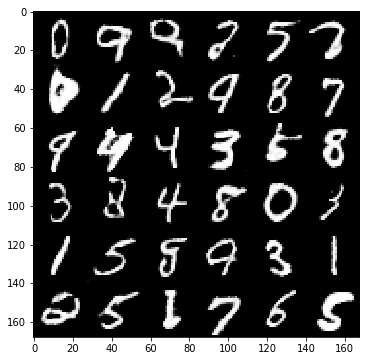

In [8]:
# Testing
# Generating images from noise, using the generator network
n = 6
canvas = np.empty((28 * n, 28 * n))

for i in range(n):
    # Noise input
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    
    # generate image from noise 
    g = sess.run(gen_sample, feed_dict={noise_input: z, 
                                        is_training: False})
    
    # rescale values to the original [0, 1] (from tanh -> [-1, 1])
    g = -1 * (g - 1)
    
    # reverse colours for better display
    g = -1 * (g - 1)
    
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = \
        g[j].reshape([28, 28])
        
plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()